# Normal modes analysis of methanol via semi-numerical method. <br /> Forces of displaced geometries are computed via automatic differentiation. <br /> Then, Hessian is computed numerically.

In [1]:
import sys
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")


import torch
from seqm.seqm_functions.constants import Constants
from seqm.Molecule import Molecule
from seqm.MolecularDynamics import Geometry_Optimization_SD
from seqm.ElectronicStructure import Electronic_Structure

import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')

/home/maxim/anaconda3/envs/hipnn_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Normal modes from optimized geometry

In [2]:
dr = 0.001 # atomic displacements
Ndisp = 18 # number of displacements (3N degrees of freedom)

### Backward displacements XYZ

In [3]:

coordinates_d = torch.tensor([[-dr, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000]])

outputs = []
for i in range(Ndisp):
    outputs.append(torch.roll(coordinates_d,shifts = (i) ))
outputs = torch.stack(outputs)
coordinates = outputs.clone() + torch.tensor([
                              [
                              [0.702557224724283, 0.009082218612640677, 0.0032799875195913897],
                              [-0.707614145212714, -0.016445490928756433, -0.0053160302976097504],
                              [-1.0976860826353918, -0.7955775292486926, 0.6962719690854523],
                              [-1.097755234761741, -0.2082662697782238, -1.0360554595036433],
                              [-1.020222647310211, 1.001104652073342, 0.33967650723822534],
                              [1.0046208851957734, -0.8579975807303093, -0.29065697404201524]
                              ]
                            ])
coordinates_0 = coordinates.to(device)
#coordinates_0

### Forward displacements XYZ

In [4]:
coordinates_d = torch.tensor([[dr, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000],
                            [0.0000, 0.0000, 0.0000]])

outputs = []
for i in range(Ndisp):
    outputs.append(torch.roll(coordinates_d,shifts = (i) ))
outputs = torch.stack(outputs)
coordinates = outputs.clone() + torch.tensor([
                              [
                              [0.702557224724283, 0.009082218612640677, 0.0032799875195913897],
                              [-0.707614145212714, -0.016445490928756433, -0.0053160302976097504],
                              [-1.0976860826353918, -0.7955775292486926, 0.6962719690854523],
                              [-1.097755234761741, -0.2082662697782238, -1.0360554595036433],
                              [-1.020222647310211, 1.001104652073342, 0.33967650723822534],
                              [1.0046208851957734, -0.8579975807303093, -0.29065697404201524]
                              ]
                            ])
coordinates_1 = coordinates.to(device)



### Elements

In [5]:
species = torch.as_tensor([[8,6,1,1,1,1]],dtype=torch.int64, device=device) \
               .expand(Ndisp,6)

### Backward displacements calculation 

In [6]:
const = Constants().to(device)


elements = [0]+sorted(set(species.reshape(-1).tolist()))

seqm_parameters = {
                   'method' : 'AM1',  # AM1, MNDO, PM#
                   'scf_eps' : 1.0e-7,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [2,0.0], # converger used for scf loop
                                         # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                         # [1], adaptive mixing
                                         # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   #'parameter_file_dir' : '../seqm/params/', # file directory for other required parameters
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True
                   }

molecule = Molecule(const, seqm_parameters, coordinates_0, species).to(device)

### Create electronic structure driver:
esdriver = Electronic_Structure(seqm_parameters).to(device)

### Run esdriver on molecules:
esdriver(molecule);

force_0 = molecule.force

### Forward displacements calculation 

In [7]:
molecule = Molecule(const, seqm_parameters, coordinates_1, species).to(device)

### Create electronic structure driver:
esdriver = Electronic_Structure(seqm_parameters).to(device)

### Run esdriver on molecules:
esdriver(molecule);

force_1 = molecule.force

### Hessian matrix

In [8]:
Hess = -((force_1 - force_0)/(2*dr)).view(18,18) #* 23.06 * 6.9477 / 1000


### Mass-weighted Hessian 

In [9]:
M_inv_rt = torch.tensor(np.diag([0.25, 0.25, 0.25,
                                 0.289, 0.289, 0.289,
                                 0.996, 0.996, 0.996,
                                 0.996, 0.996, 0.996,
                                 0.996, 0.996, 0.996,
                                 0.996, 0.996, 0.996]), device = device)

WeightedHess = M_inv_rt@(Hess.clone()@M_inv_rt)

In [10]:
### Eigenvalues and eigenvectors

In [11]:
e_val, e_vec = torch.linalg.eigh(WeightedHess)

### Convert Eigenvalues to cm$^{-1}$

In [12]:
const = (23.06054 * 6.9477 / 1000)**0.5*1302.8
freq_ar = []
for e in e_val[6:]:
    freq_ar.append((e.item())**0.5*const)

## Intensities

### Get vibrational coordinates

In [13]:
vib_coord = []
for e in e_vec[6:]:
    vib_coord.append(e.view(6,3))
vib_coord = torch.stack(vib_coord)

### Displacements along vibrational coordinates (backward and forward)

In [14]:
dq = 0.001
coordinates = -vib_coord.clone()*dq + torch.tensor([
                              [
                              [0.702557224724283, 0.009082218612640677, 0.0032799875195913897],
                              [-0.707614145212714, -0.016445490928756433, -0.0053160302976097504],
                              [-1.0976860826353918, -0.7955775292486926, 0.6962719690854523],
                              [-1.097755234761741, -0.2082662697782238, -1.0360554595036433],
                              [-1.020222647310211, 1.001104652073342, 0.33967650723822534],
                              [1.0046208851957734, -0.8579975807303093, -0.29065697404201524]
                              ]
                            ], device = device)
coordinates_0 = coordinates.to(device)
species = torch.as_tensor([[8,6,1,1,1,1]],dtype=torch.int64, device=device) \
               .expand(vib_coord.shape[0],6)


coordinates = vib_coord.clone()*dq + torch.tensor([
                              [
                              [0.702557224724283, 0.009082218612640677, 0.0032799875195913897],
                              [-0.707614145212714, -0.016445490928756433, -0.0053160302976097504],
                              [-1.0976860826353918, -0.7955775292486926, 0.6962719690854523],
                              [-1.097755234761741, -0.2082662697782238, -1.0360554595036433],
                              [-1.020222647310211, 1.001104652073342, 0.33967650723822534],
                              [1.0046208851957734, -0.8579975807303093, -0.29065697404201524]
                              ]
                            ], device = device)
coordinates_1 = coordinates.to(device)
species = torch.as_tensor([[8,6,1,1,1,1]],dtype=torch.int64, device=device) \
               .expand(vib_coord.shape[0],6)

### Backward displacements calculation 

In [15]:
const = Constants().to(device)

elements = [0]+sorted(set(species.reshape(-1).tolist()))

molecule = Molecule(const, seqm_parameters, coordinates_0, species).to(device)

### Create electronic structure driver:
esdriver = Electronic_Structure(seqm_parameters).to(device)

### Run esdriver on molecules:
esdriver(molecule);

d_0 = molecule.d
D_0 = (d_0[:,0]**2 + d_0[:,1]**2 + d_0[:,2]**2)**0.5

### Forward displacements calculation 

In [16]:
const = Constants().to(device)
#may need to add scaling factor for length and energy on const, check constants.py

molecule = Molecule(const, seqm_parameters, coordinates_1, species).to(device)

### Create electronic structure driver:
esdriver = Electronic_Structure(seqm_parameters).to(device)

### Run esdriver on molecules:
esdriver(molecule);

d_0 = molecule.d
D_1 = (d_0[:,0]**2 + d_0[:,1]**2 + d_0[:,2]**2)**0.5

### Calculate intensities

In [17]:
intensity = (  (D_1 - D_0)/dq )**2


### Plot

Text(0.5, 0, '$\\nu$ (cm$^{-1}$)')

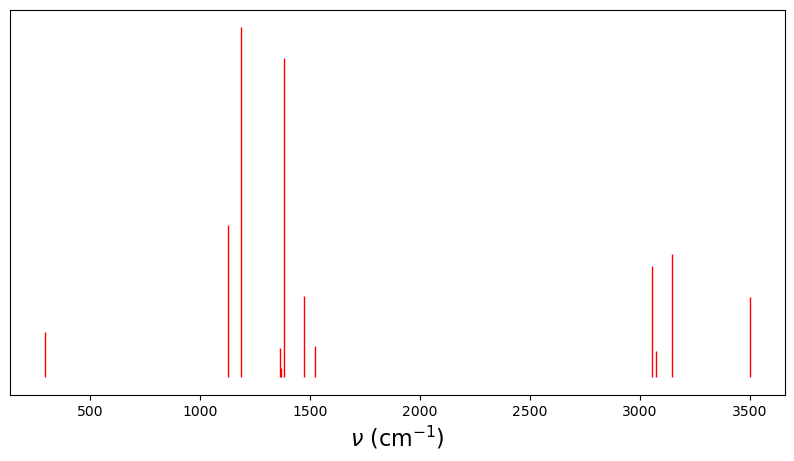

In [18]:
plt.figure().set_size_inches(10,5)
plt.yticks([])

plt.vlines(x=freq_ar, ymin=0, ymax=intensity, colors='r', ls='-', lw=1, label='Normal modes')
plt.xlabel(r'$\nu$ (cm$^{-1}$)', fontsize=16)
